<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#accumulate-the-vertical-flux-profile-for-each-of-the-10-ensemble-members--into-the-avg_flux-variable" data-toc-modified-id="accumulate-the-vertical-flux-profile-for-each-of-the-10-ensemble-members--into-the-avg_flux-variable-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>accumulate the vertical flux profile for each of the 10 ensemble members  into the avg_flux variable</a></span></li><li><span><a href="#use-searchsorted-and-argmin-to-get-the-first-zero-crossing-for-each-of-the-48-profiles" data-toc-modified-id="use-searchsorted-and-argmin-to-get-the-first-zero-crossing-for-each-of-the-48-profiles-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>use searchsorted and argmin to get the first zero crossing for each of the 48 profiles</a></span></li><li><span><a href="#look-at-variablity-among-ensemble-members-at-timestep-20" data-toc-modified-id="look-at-variablity-among-ensemble-members-at-timestep-20-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>look at variablity among ensemble members at timestep 20</a></span></li><li><span><a href="#Does-the-inversion-height-grow-as-sqrt(time)?" data-toc-modified-id="Does-the-inversion-height-grow-as-sqrt(time)?-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>Does the inversion height grow as sqrt(time)?</a></span></li></ul></li></ul></li></ul></div>

# Introduction

This notebook picks off the point at which the buoyancy flux crosses the 0 point -- i.e. the bottom of the entrainment layer

In [1]:
import urllib,os
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import numpy as np
import a500

from  a500.utils.data_read import download
the_root="http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/"
the_file='case_60_10.nc'
out=download(the_file,root=the_root,dest_folder=a500.data_dir)



def make_theta(temp,press):
    """
      temp in K
      press in Pa
      returns theta in K
    """
    p0=1.e5
    Rd=287.  #J/kg/K
    cpd=1004.  #J/kg/K
    theta=temp*(p0/press)**(Rd/cpd)
    return theta

through /Users/phil/repos/a500_notebooks/a500/__init__.py pha II
trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/data//case_60_10.nc
writing to: /Users/phil/repos/a500_notebooks/data/case_60_10.nc

case_60_10.nc already exists
and is 499251027 bytes
will not overwrite



### accumulate the vertical flux profile for each of the 10 ensemble members  into the avg_flux variable

In [2]:
case_name='case_60_10.nc'
#
#  look at the first ensemble member
#

with Dataset(case_name,'r') as ncin:
    ensemble='c1'
    group = ncin.groups['c1']
    the_shape = group.variables['TABS'].shape
    avg_flux=np.zeros(the_shape[:2],dtype=np.float64)
    grouplist=np.arange(1,11)
    groupnames=['c{:d}'.format(groupnum) for groupnum in grouplist]
    for count,the_group in enumerate(groupnames):
        print('working on {}'.format(the_group))
        group = ncin.groups[the_group]
        temp=group.variables['TABS'][...]
        wvel = group.variables['W'][...]
        horiz_mean_temp = temp.mean(axis=3).mean(axis=2)
        horiz_mean_wvel = wvel.mean(axis=3).mean(axis=2)
        temp = temp.T - horiz_mean_temp.T
        wvel = wvel.T - horiz_mean_wvel.T
        flux =(temp*wvel).T
        horiz_mean_flux = flux.mean(axis=3).mean(axis=2)
        avg_flux += horiz_mean_flux
    avg_flux = avg_flux/len(groupnames)
    press=ncin.variables['press'][...]
    z=ncin.variables['z'][...]
    the_time=ncin.variables['time'][...]

working on c1
working on c2
working on c3
working on c4
working on c5
working on c6
working on c7
working on c8
working on c9
working on c10


### use searchsorted and argmin to get the first zero crossing for each of the 48 profiles

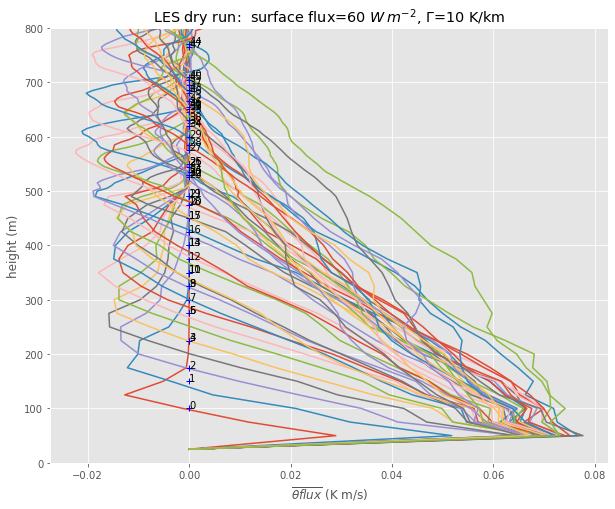

In [3]:
%matplotlib inline
plt.style.use('ggplot')
fig,ax=plt.subplots(1,1,figsize=(10,8))
zstore=[]
for i in np.arange(0,avg_flux.shape[0],1):
    #ax.plot(avg_flux[i,:],z,'ro')
    ax.plot(avg_flux[i,:],z)
    negheight=np.argmin(avg_flux[i,:])
    zero_cross = np.searchsorted(-avg_flux[i,2:negheight],0.)
    z_trun = z[2:negheight]
    zstore.append(z_trun[zero_cross])
    ax.text(0,z_trun[zero_cross],'{:d}'.format(i))
    ax.plot(0,z_trun[zero_cross],'b+')
out=ax.set(xlabel=r'$\overline{\theta flux}$ (K m/s)',ylabel='height (m)',
           title='LES dry run:  surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km',
           ylim=[0,800])

dump_profs=True
if dump_profs:
    save_dict=dict(z=z,avg_flux=avg_flux,the_time=the_time)
    np.savez('flux_profs',**save_dict)



### look at variablity among ensemble members at timestep 20

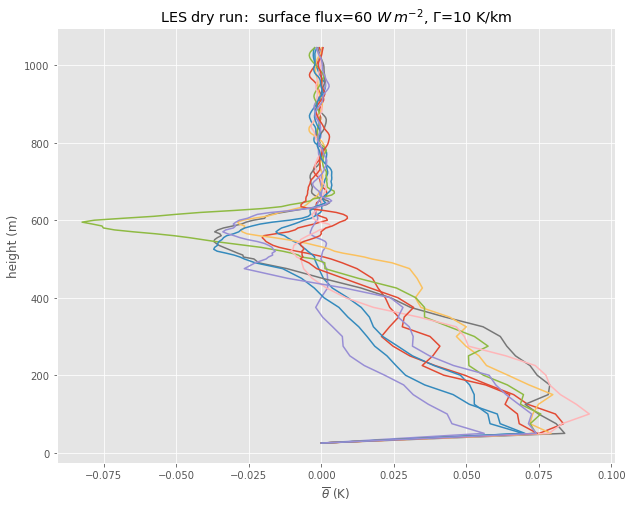

In [4]:
timestep = 20
hold_vals=np.empty([len(groupnames),the_shape[1]])
with Dataset(case_name,'r') as ncin:
    for count,the_group in enumerate(groupnames):
        group = ncin.groups[the_group]
        temp=group.variables['TABS'][timestep,...]
        wvel = group.variables['W'][timestep,...]
        horiz_mean_temp = temp.mean(axis=2).mean(axis=1)
        horiz_mean_wvel = wvel.mean(axis=2).mean(axis=1)
        temp = temp.T - horiz_mean_temp.T
        wvel = wvel.T - horiz_mean_wvel.T
        flux =(temp*wvel).T
        horiz_mean_flux = flux.mean(axis=2).mean(axis=1)
        hold_vals[count,:]=horiz_mean_flux

fig,ax=plt.subplots(1,1,figsize=(10,8))
for i in range(hold_vals.shape[0]):
    ax.plot(hold_vals[i,:],z)
out=ax.set(xlabel=r'$\overline{\theta}$ (K)',ylabel='height (m)',
       title='LES dry run:  surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km')


### Does the inversion height grow as sqrt(time)?

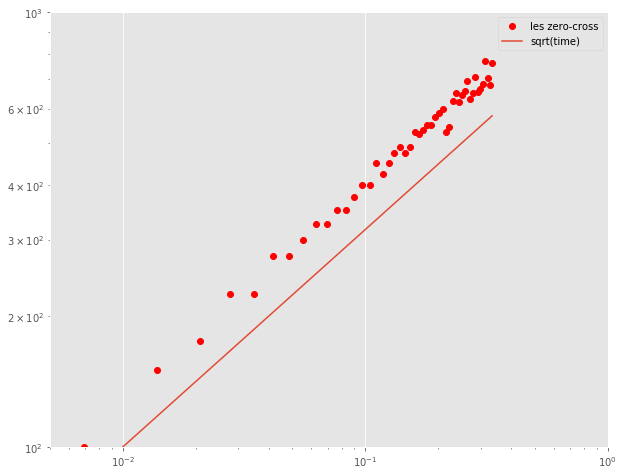

In [5]:
fig,ax=plt.subplots(1,1,figsize=(10,8))
day_frac=the_time - 169
ax.loglog(day_frac,zstore,'ro',label='les zero-cross')
ax.loglog(day_frac,1000.*np.sqrt(day_frac),label='sqrt(time)')
ax.set(ylim=[100,1000],xlim=[5.e-3,1])
out=ax.legend()

